In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.cluster.vq import kmeans2
import time
from gpflow import set_trainable
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

from gp4gw.sample_fast_test import SampleLogJoint
import gp4gw.bbh_example as bbh_example
from gp4gw.data_preparation import *
from gp4gw.training_tools import *
from gp4gw.deep_kernel import DeepKernel

# Make plots inline
%matplotlib inline
import matplotlib
import corner

2021-11-18 17:08:34.080924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import warnings
warnings.filterwarnings("ignore")

# tf.random.set_seed(0)
import os
aPath = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11/'
os.environ['XLA_FLAGS'] = aPath

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-11-18 17:08:36.023637: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-18 17:08:36.024804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-18 17:08:36.042408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-11-18 17:08:36.042436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-18 17:08:36.043971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-18 17:08:36.044017: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

# Load PE samples and prepare data
Sample file can be found on my HAWK namedir: `/home/virginia.demilio/GP-Project-PE/posterior_samples/production_injections/16s_prior_powerlaw/result/16s_prior_powerlaw_data0_0_analysis_H1L1V1_dynesty_result.json`

In [6]:
data_path='../posterior_samples/16s_prior_powerlaw_data0_0_analysis_H1L1V1_dynesty_result.json'

In [7]:
analytic_priors = bbh_example.priors_from_bilby_object(data_path)
param_names = bbh_example.sampled_parameters(analytic_priors)

my_data = scale_data(**bbh_example.load_data(path=data_path, param_names=param_names, samples_frac=1.0))
parameters_scaler = my_data["x_scaler"]
likelihood_scaler = my_data["y_scaler"]

Shape of x-data: N=25087, Q=8


In [8]:
my_data["x_train"].shape

(25087, 8)

In [9]:
X = tf.convert_to_tensor(my_data["x_train"], dtype=tf.float64)
Y = tf.convert_to_tensor(my_data["y_train"].reshape(-1, 1), dtype=tf.float64)

N, Q = X.shape
print(f'X_train shape: {N}, {Q}; Y_train shape: {Y.shape}')

X_train shape: 25087, 8; Y_train shape: (25087, 1)


2021-11-18 17:08:37.375191: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-18 17:08:37.377563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-11-18 17:08:37.377598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-18 17:08:37.377643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-18 17:08:37.377653: I tensorflow/stream_executor

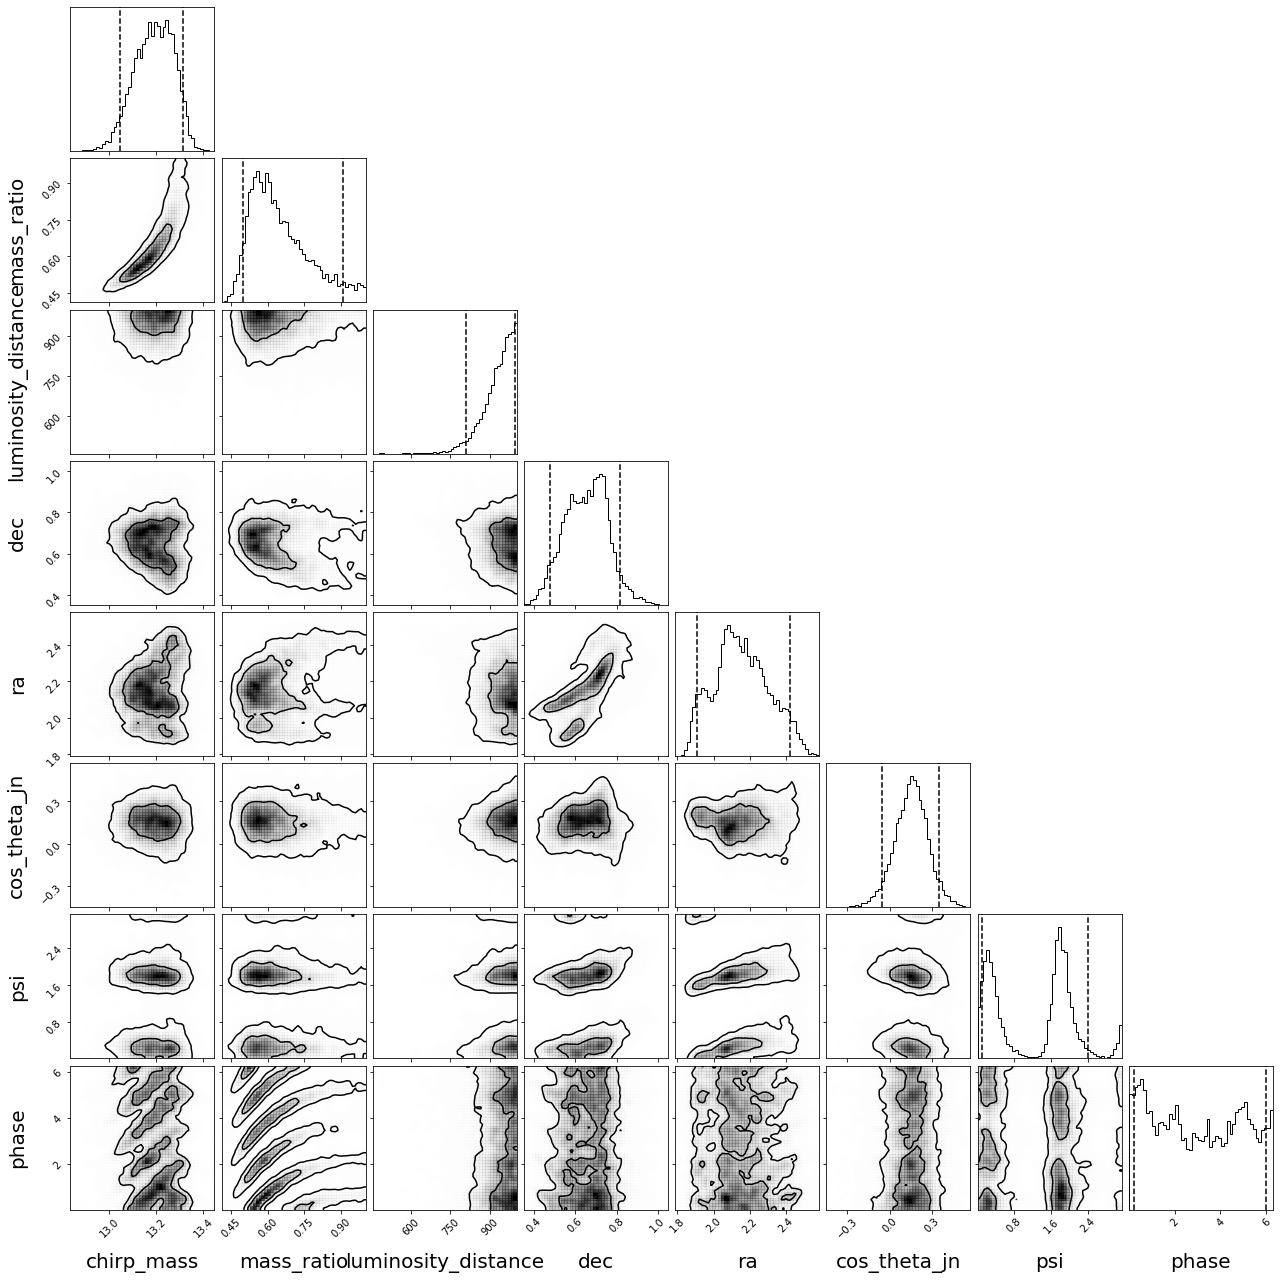

In [10]:
fig1 = corner.corner(
    parameters_scaler.inverse_transform(my_data['x_train']),
    bins=50,
    labels=param_names,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="k",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

# Build GP model

Here we define the mean function to be min(log likelihod) - 50

In [11]:
data_dim = X.shape[1]

In [12]:
k1 = gpflow.kernels.SquaredExponential(
    active_dims=[param_names.index('chirp_mass'),
                param_names.index('mass_ratio'),
                param_names.index('luminosity_distance'),
                param_names.index('dec'),
                param_names.index('cos_theta_jn'),
                 param_names.index('psi'),
                 param_names.index('phase'),
                 param_names.index('ra')], lengthscales=[0.1]*data_dim , variance=1.0)

k4 = gpflow.kernels.Matern12(
    active_dims=[param_names.index('chirp_mass'),
                param_names.index('mass_ratio'),
                param_names.index('luminosity_distance'),
                param_names.index('dec'),
                param_names.index('cos_theta_jn'),
                 param_names.index('psi'),
                 param_names.index('phase'),
                 param_names.index('ra')], lengthscales=[1.0]*data_dim , variance=1.0)

kperiodic = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(
    active_dims=[param_names.index('psi'),
                 param_names.index('phase'),
                 param_names.index('ra')], lengthscales = 0.1, variance=1.0))

kernel = DeepKernel(
    data_dim, data_dim, k1*k4*kperiodic
)

In [13]:
M = 500 # number of inducing points

In [14]:
X.shape

TensorShape([25087, 8])

In [15]:
Z = kmeans2(X.numpy(), M, minit="points")[0]

# Initialise hyperparameters here
# init_method = robustgp.ConditionalVariance()
# Z = init_method.compute_initialisation(X.numpy(), M, kernel)[0]

model = gpflow.models.SGPR(
   (X, Y), kernel, inducing_variable=Z, mean_function=gpflow.mean_functions.Constant(min(Y)-10), noise_variance=1.01e-5
)

# start_time = time.time()
# for _ in range(10):
#     # Optimise w.r.t. hyperparmeters here...
#     Z = init_method.compute_initialisation(X.numpy(), M, kernel)[0]  # Reinit with the new kernel hyperparameters
#     model.inducing_variable.Z = gpflow.Parameter(Z)
# print("--- Computing inducing points took %s minutes ---" % ((time.time() - start_time) / 60))

In [16]:
# mean, cov = model.predict_y(X)
# plt.plot((mean - Y))
# print('Test MAE: {}'.format(np.mean(np.abs(mean - Y))))

In [17]:
set_trainable(model.mean_function, True)

2021-11-18 17:08:44.477250: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [18]:
adam_learning_rate=0.1
lr_schedule=True

In [19]:
nepochs=100

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-11-18 17:08:45.849643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-18 17:08:45.859034: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700000000 Hz
2021-11-18 17:08:46.373641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-18 17:08:46.526580: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x5569a95e24b0
2021-11-18 17:08:46.526774: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2021-11-18 17:08:46.741459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epoch 10: LOSS (train) 379187832.8355746, MSE 0.30875439581833025
Epoch 20: LOSS (train) 283128427.0813074, MSE 0.23455960882834584
Epoch 30: LOSS (train) 214014065.25122762, MSE 0.18409697835552877
Epoch 40: LOSS (train) 175280295.24015248, MSE 0.15688752570687511
Epoch 50: LOSS (train) 160566701.11498868, MSE 0.14764988080365696
Epoch 60: LOSS (train) 155300665.17743695, MSE 0.14841403315497503
Epoch 70: LOSS (train) 135528887.31524312, MSE 0.13306243563857229
Epoch 80: LOSS (train) 121788831.38711274, MSE 0.12256634653131254
Epoch 90: LOSS (train) 110961257.23992604, MSE 0.1148267131841955
Epoch 100: LOSS (train) 110822370.97451925, MSE 0.11801313513792404
--- Training took 0.3050755818684896 minutes ---
Training error: 0.11801313513792404


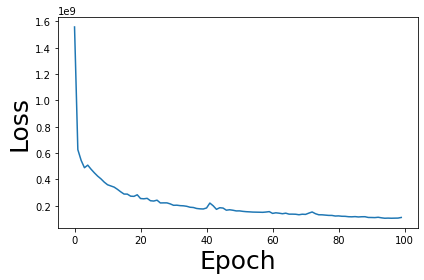

In [20]:
if lr_schedule:
    lr = InverseTimeDecay(
        adam_learning_rate,
        decay_steps=int(nepochs / 4),
        decay_rate=1,
        staircase=False)
else:
    lr = adam_learning_rate

start_time = time.time()


only_training_loop_exact_GP(
    model,
    X = X,
    Y = Y,
    optimizer=tf.keras.optimizers.Adam(lr),
    epochs=nepochs
)
print("--- Training took %s minutes ---" % ((time.time() - start_time) / 60))
print(
    f"Training error: {mean_squared_error(Y, model.predict_y(X)[0])}"
)

In [21]:
# 19.99min CPUs

# Assessing model accuracy

In [22]:
mean, cov = model.predict_y(X)

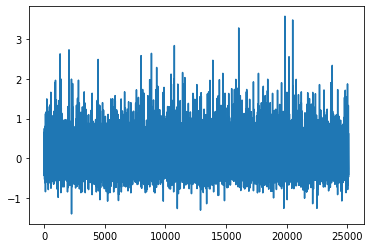

In [23]:
plt.plot((mean - Y))

In [24]:
print('Test MAE: {}'.format(np.mean(np.abs(mean - Y))))

Test MAE: 0.24744038039423955


In [25]:
# Trainable mean function MAE: 0.28

# Sample GP model

In [26]:
X_scaled = my_data['x_scaler'].inverse_transform(my_data['x_train'])

In [27]:
mcmc_points = 8000
num_chains = 10
num_burnin = mcmc_points * 0.3
initialise_chains = np.mean(X, axis=0)

In [28]:
quick_priors = bbh_example.quick_priors(X_scaled, param_names, analytic_priors)

Loading non-scaled priors bounds


In [29]:
sample = SampleLogJoint(
    predict_log_joint_mean_var=model.predict_f,
    analytic_priors=quick_priors,
    param_names=param_names,
    parameters_scaler=my_data['x_scaler'],
    log_joint_scaler=my_data['y_scaler'],
)

In [30]:
print(f'mcmc_points: {mcmc_points}, num_burnin: {int(num_burnin)}')
start_time = time.time()
print("Running chain..")
all_samples = sample.run_chain(
    num_results=mcmc_points,
    num_burnin_steps=int(num_burnin),
    initialise_chains=initialise_chains + 1e-3 * np.random.randn(num_chains, X.shape[1]),
    num_chains=num_chains,
    sampler='HMC',
)
print("--- Sampling took %s minutes ---" % ((time.time() - start_time) / 60))

mcmc_points: 8000, num_burnin: 2400
Running chain..
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Running sampler with SimpleStepSizeAdaptation


2021-11-18 17:09:05.754469: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5569d4a7a270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-11-18 17:09:05.754508: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2021-11-18 17:09:05.948634: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:241] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired.
2021-11-18 17:09:11.163847: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


--- Sampling took 28.88582751353582 minutes ---


In [31]:
# 17.16min CPUs

In [32]:
combine_chains = np.zeros((mcmc_points * num_chains, len(param_names)))
for i in range(len(param_names)):
    combine_chains[:, i] = all_samples[:, :, i].numpy().flatten()
gp_samples = my_data['x_scaler'].inverse_transform(combine_chains)

In [33]:
az_data = convert_to_arviz_data(all_samples, my_data['x_scaler'], param_names)

In [34]:
print(az.summary(az_data)['r_hat'])

chirp_mass             1.11
mass_ratio             1.16
luminosity_distance    1.02
dec                    1.07
ra                     1.26
cos_theta_jn           1.04
psi                    1.35
phase                  1.22
Name: r_hat, dtype: float64


In [35]:
latex_names = {
    'chirp_mass': r'$\mathcal{M}$',
    'mass_ratio': r'q',
    'a_1': r'$a_1$',
    'a_2': r'$a_2$',
    'luminosity_distance': r'$d_{L}$',
    'phase': r'$\phi$',
    'psi': r'$\psi$',
    'dec': r'dec',
    'ra': r'ra',
    'cos_theta_jn': r'$cos(\theta_{jn})$'
              }

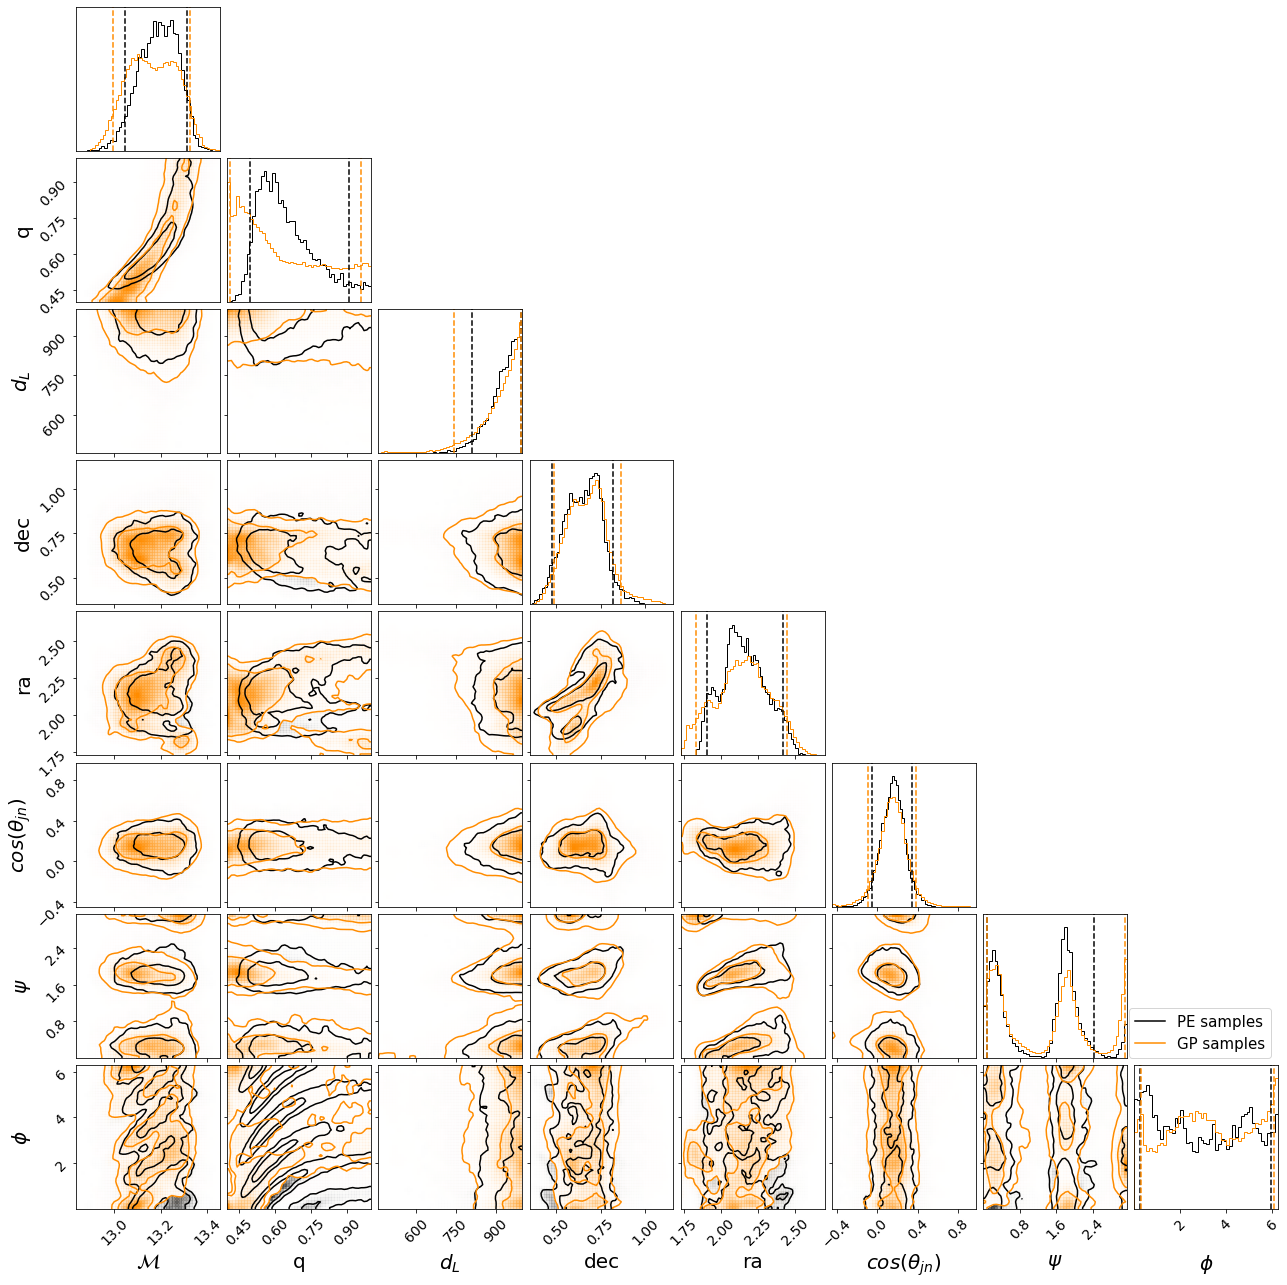

In [36]:
blue_line = matplotlib.lines.Line2D([], [], color="k", label="PE samples")
red_line = matplotlib.lines.Line2D([], [], color="darkorange", label="GP samples")
fig1 = corner.corner(
    parameters_scaler.inverse_transform(my_data['x_train']),
    bins=50,
    labels=[latex_names[key] for key in param_names],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="k",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig = corner.corner(
    gp_samples,
    fig=fig1,
    bins=50,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    labels=[latex_names[key] for key in param_names],
    color="darkorange",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig.get_axes()[4].tick_params(which="major", bottom=False)
fig.get_axes()[5].tick_params(which="both", bottom=False)
fig.get_axes()[8].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", left=False)
fig.get_axes()[10].tick_params(which="both", bottom=False)
fig.get_axes()[13].tick_params(which="both", left=False)
fig.get_axes()[14].tick_params(which="both", left=False)
fig.get_axes()[0].tick_params(which="both", bottom=False)

for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=14)

plt.legend(
    handles=[blue_line, red_line],
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc=4,
    fontsize=15,
)

# plt.savefig("GP_likelihood_8D_ProdK_kpsi_kphase_kra.png")